### Importing Data from the Open ML Dataset

In [49]:
# Import libraries
import openml
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

In [2]:
# Load the diamond dataset from OpenML
dataset = openml.datasets.get_dataset(42225)  # Diamond dataset ID on OpenML
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)

In [3]:
# Explore the dataset
df = pd.concat([X, y], axis=1)
print("Dataset Shape:", df.shape)
print(df.head())

Dataset Shape: (53940, 10)
   carat      cut color clarity  depth  table     x     y     z  price
0   0.23    Ideal     E     SI2   61.5   55.0  3.95  3.98  2.43    326
1   0.21  Premium     E     SI1   59.8   61.0  3.89  3.84  2.31    326
2   0.23     Good     E     VS1   56.9   65.0  4.05  4.07  2.31    327
3   0.29  Premium     I     VS2   62.4   58.0  4.20  4.23  2.63    334
4   0.31     Good     J     SI2   63.3   58.0  4.34  4.35  2.75    335


/opt/blue-python/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


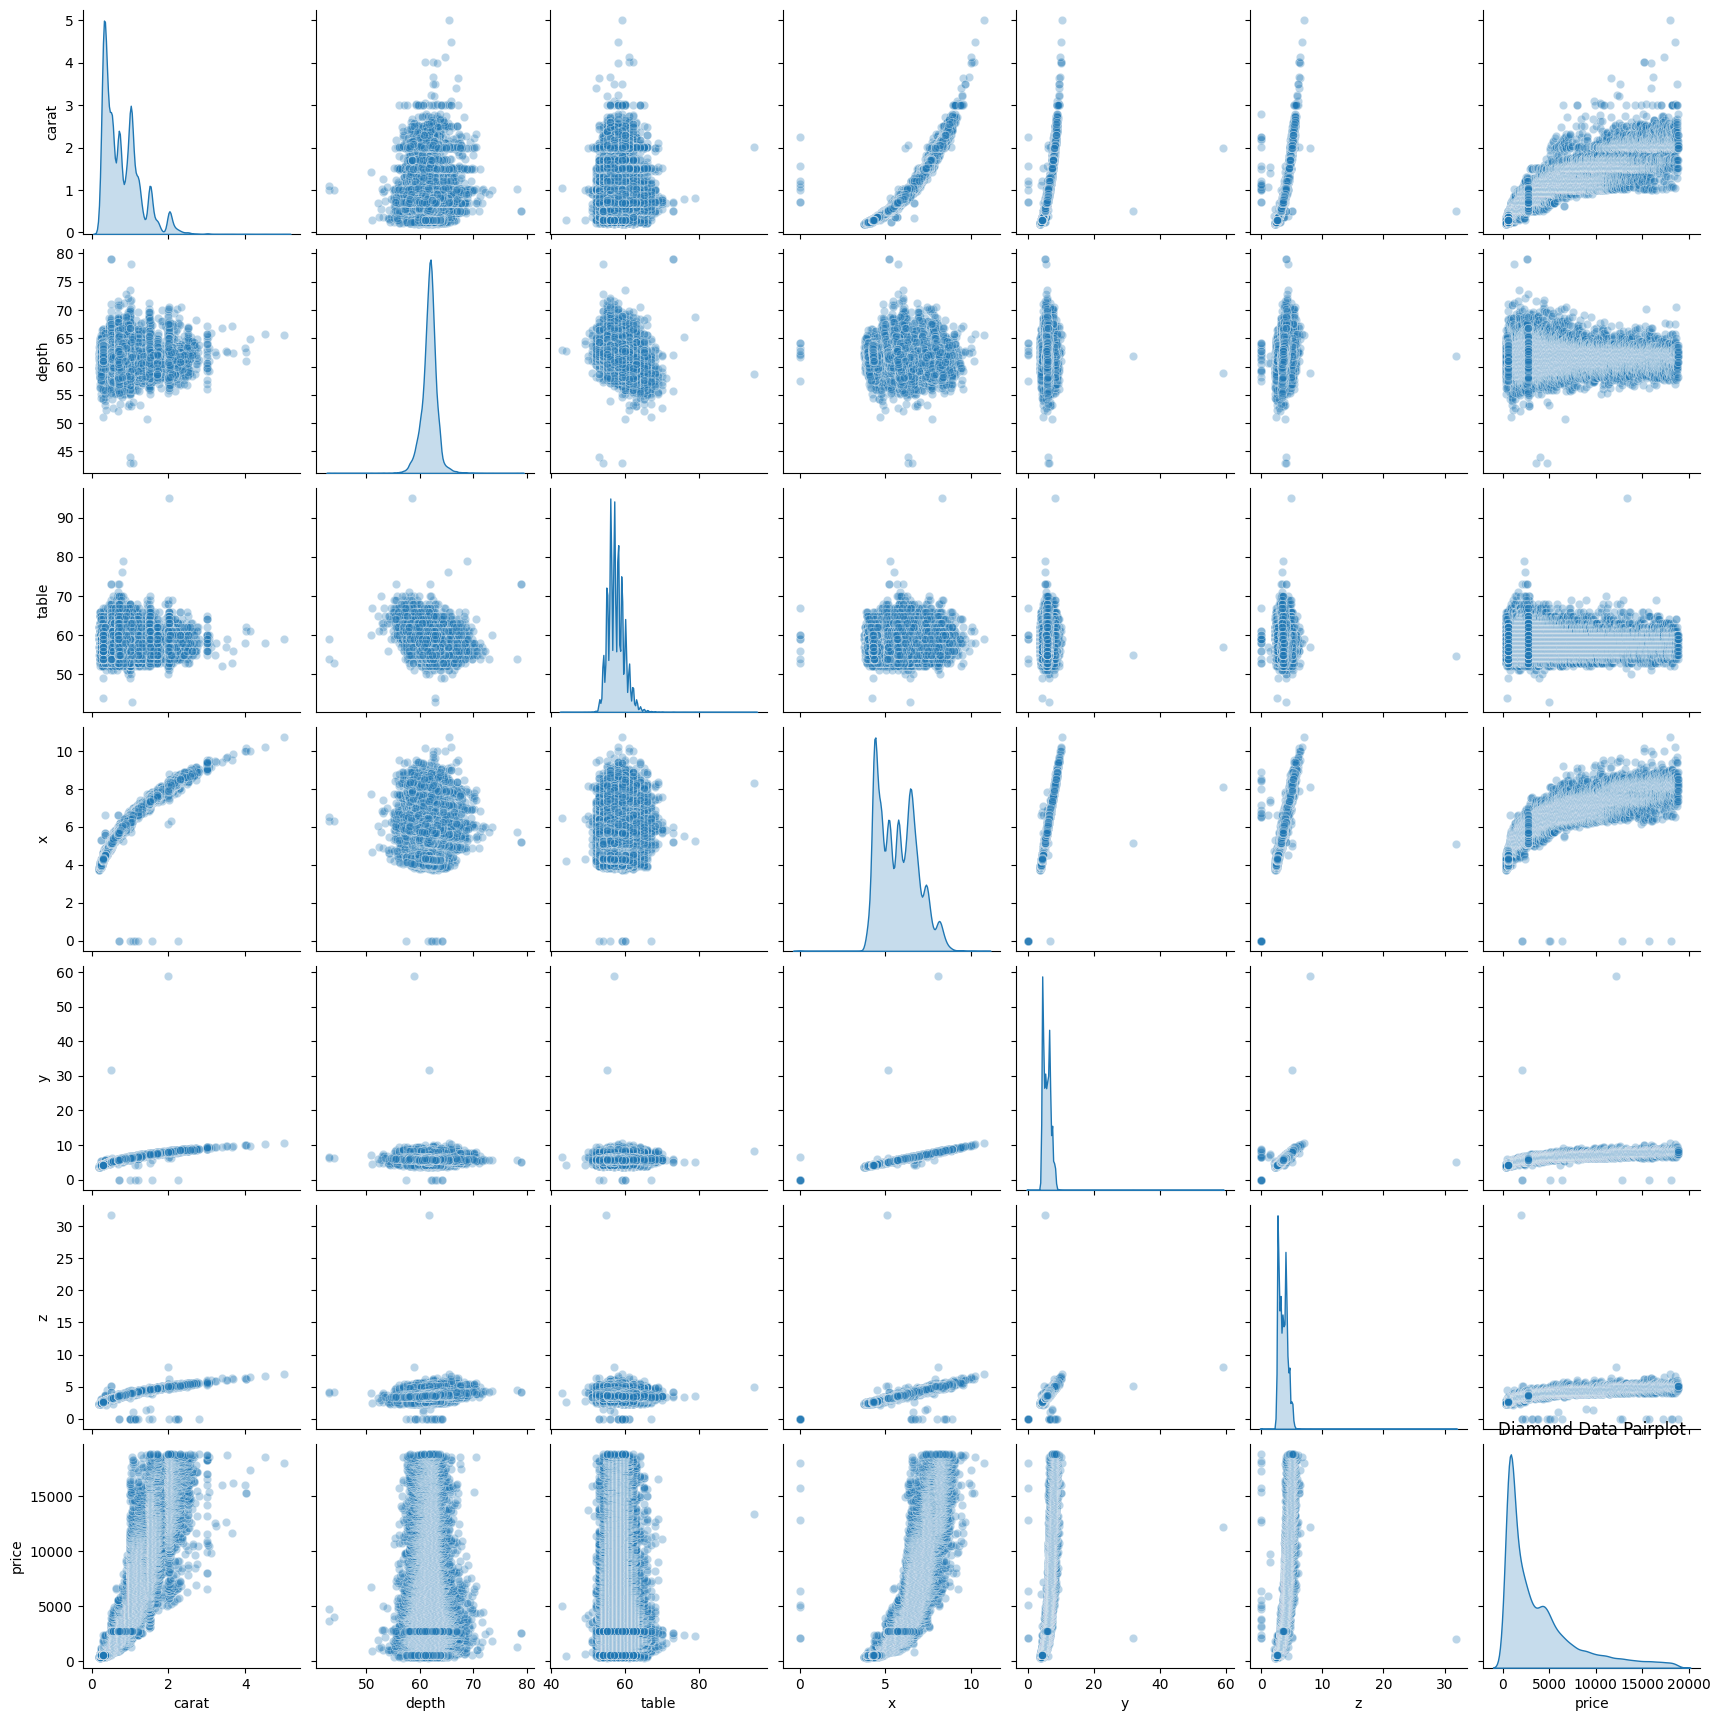

In [4]:
# Basic visualization
sns.pairplot(df, diag_kind='kde',plot_kws={'alpha': 0.3})
plt.title('Diamond Data Pairplot')
plt.show()

### Insights From this Visualization
1. Carat vs. Price:
   - strong positive correlation between carat weight and price
   - a few high-carat diamonds have extremely high prices, which skews the distribution.
2. Depth and Table vs. Price:
   - depth and table do not show strong relationship with price-> they are not the best predictors
3. x,y,z vs Price:
   - x,y,z are highly correlated with each other
   - they also higly correlate with carat, but with some outliers

To Improve the visualization and get more insights we did the following modifications on the data:
1. Applied log transformation on "price" -> the price distribution was heavily right skewed with a long tail (there were a few veryhigh priced diamond), therefore the mean was much higher the median, this can be missleading, with log transformation we made it to normal ()the extreme values have less influance with this)
2. Using Volume which = X*Y*Z _> this volume represents the overall dimaon size

In [5]:
# Statistical summary of numerical features before Feature engineering
print(df.describe())

# Check for null values in the dataset
print("Null Values in Dataset:\n", df.isnull().sum())

# Distribution of target variable
print("Target Variable Distribution:\n", y.value_counts())

              carat         depth         table             x             y  \
count  53940.000000  53940.000000  53940.000000  53940.000000  53940.000000   
mean       0.797940     61.749405     57.457184      5.731157      5.734526   
std        0.474011      1.432621      2.234491      1.121761      1.142135   
min        0.200000     43.000000     43.000000      0.000000      0.000000   
25%        0.400000     61.000000     56.000000      4.710000      4.720000   
50%        0.700000     61.800000     57.000000      5.700000      5.710000   
75%        1.040000     62.500000     59.000000      6.540000      6.540000   
max        5.010000     79.000000     95.000000     10.740000     58.900000   

                  z         price  
count  53940.000000  53940.000000  
mean       3.538734   3932.799722  
std        0.705699   3989.439738  
min        0.000000    326.000000  
25%        2.910000    950.000000  
50%        3.530000   2401.000000  
75%        4.040000   5324.250000  


### Isnights From the descriptive statistics:
1. Carat & Price are right-skewed → Consider log transformation.
2. Some diamonds have x = 0, y = 0, z = 0 → Potential data errors, should be removed.
3. Volume (x × y × z) could be a better feature than separate x, y, z.
4. Extreme depth & table values exist → Filter or investigate further.

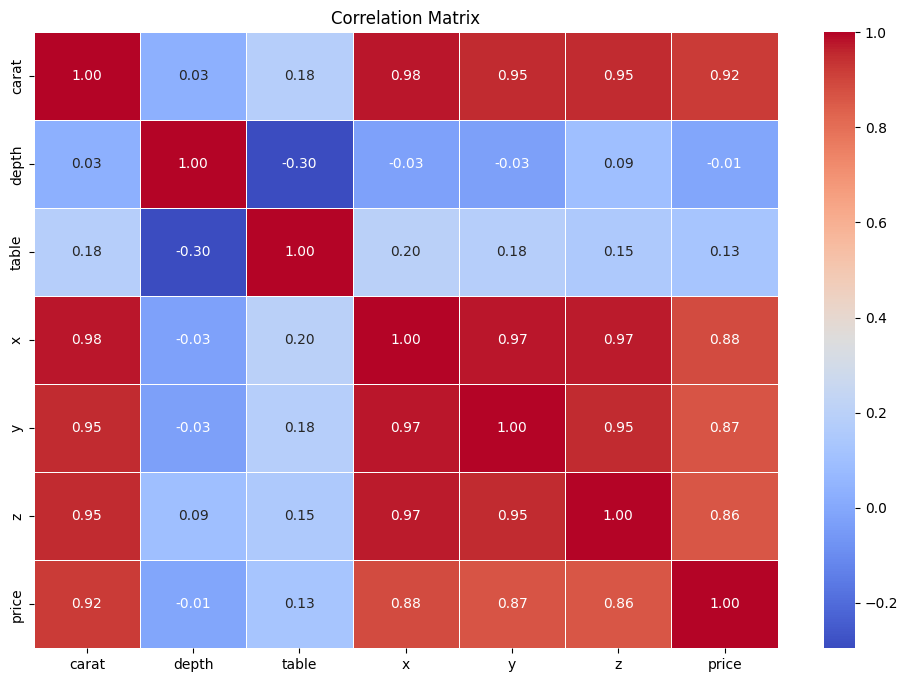

In [6]:
# Correlation matrix excluding categorical columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

### Insights from the Correlation Heatmap:
- Carat weight is highly correlated with diamond dimensions (x, y, z), meaning larger diamonds tend to have bigger dimensions
- Carat is the strongest predictor of price—as expected, larger diamonds are more expensive.
- Since x, y, z are highly correlated with carat, their relationship with price is also strong.
- Depth and table do not significantly impact price, suggesting they are less useful predictors-> these features affect a diamond’s appearance but not necessarily its price directly

In [4]:
# Assuming df is the original dataset
df_pre = df.copy()  # Copy original data

# Step 1: Create the 'volume' feature
df_pre["volume"] = df_pre["x"] * df_pre["y"] * df_pre["z"]

# Step 2: Apply log transformation to 'price'
df_pre["log_price"] = np.log(df_pre["price"])

# Step 3: Keep only the required columns
df_pre = df_pre[["carat","cut",'color', 'clarity', "depth", "table", "volume", "log_price"]]

/opt/blue-python/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


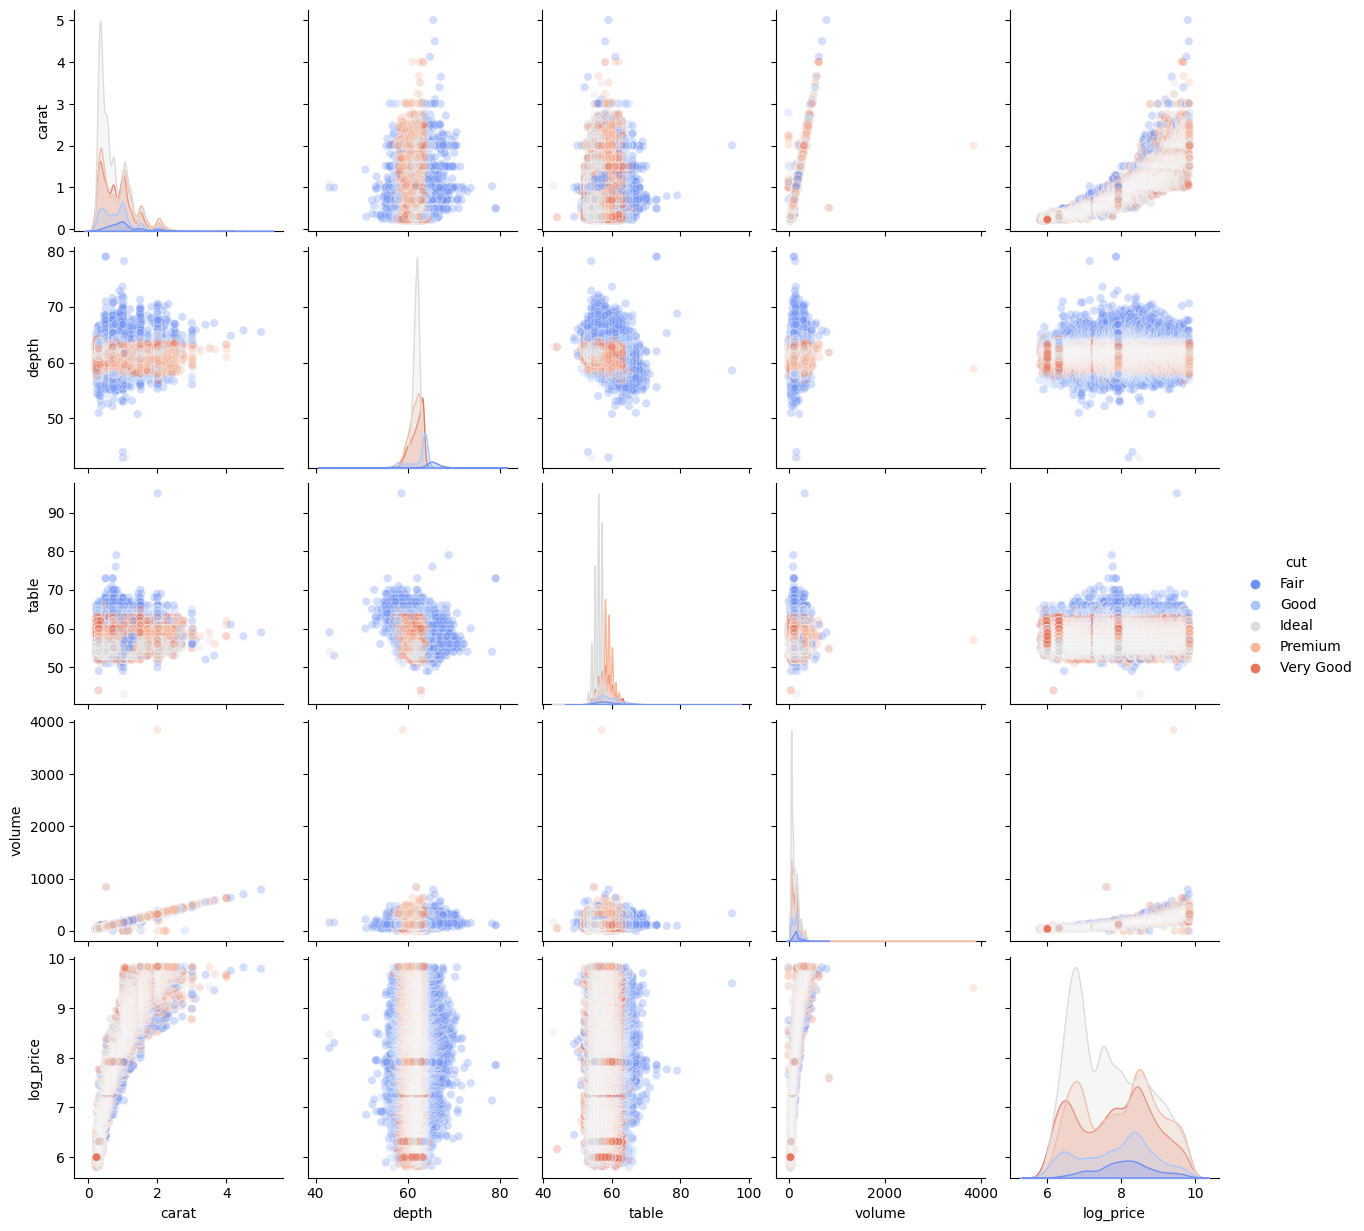

In [10]:
# Create improved pair plot
sns.pairplot(df_pre, 
             vars=["carat", "depth", "table", "volume", "log_price"], 
             hue="cut",  # Add categorical variable
             palette="coolwarm", 
             plot_kws={'alpha': 0.3})

### Visual 2.
This pair plot (scatterplot matrix) provides insights into the relationships between different diamond attributes, including carat, depth, table, volume, and log-transformed price (log_price). The colors represent different diamond cuts (Fair, Good, Ideal, Premium, Very Good).

#### Insights
- strong positive correlation between carat and price (log price)
- higher cara diamonds tend to have higher prices, but there are variations based on cut quality
- fair cut diamonds tend to be cheaper than premium and ideal cuts
- Volume shows a weak, non-linear correlation with price
- some diamonds have unexpectdly low prices for hight volumes-> these can be misclassified diamonds
- depth and table do not show strong correlations with price-> most values are concentrated around the standard diamond proportion
- distribution of depth is fairly normal, while table has some outliers
- depth and table alone are not strong predictors of the price, but they still might have a little influence
- the log prices shows better after then the raw price -> Ideal and Premium cuts have higher prices on avg, while fair and Godd cuts have wider price spread

### Data Issues
- outliers in volume, depth and table can be due to data entry errors or unusual diamonds
- some high volume diamonds have unexpectedly low prices (-> we might handle this)

### Get Descriptive Stats about the modified data

In [11]:
# Statistical summary of numerical features before Feature engineering
print(df_pre.describe())

# Check for null values in the dataset
print("Null Values in Dataset:\n", df_pre.isnull().sum())

# Distribution of target variable
print("Target Variable Distribution:\n", y.value_counts())


              carat         depth         table        volume     log_price
count  53940.000000  53940.000000  53940.000000  53940.000000  53940.000000
mean       0.797940     61.749405     57.457184    129.849403      7.786768
std        0.474011      1.432621      2.234491     78.245262      1.014649
min        0.200000     43.000000     43.000000      0.000000      5.786897
25%        0.400000     61.000000     56.000000     65.136830      6.856462
50%        0.700000     61.800000     57.000000    114.808572      7.783641
75%        1.040000     62.500000     59.000000    170.842451      8.580027
max        5.010000     79.000000     95.000000   3840.598060      9.842835
Null Values in Dataset:
 carat        0
cut          0
depth        0
table        0
volume       0
log_price    0
dtype: int64
Target Variable Distribution:
 605      132
802      127
625      126
828      125
776      124
        ... 
13061      1
13074      1
13075      1
13077      1
13078      1
Name: price, L

### Isnights From the descriptive statistics:

#### Carat (Diamond Weight)
Mean: 0.798, Median: 0.7, Max: 5.01
Most diamonds are less than 1 carat (as seen from the 25th percentile (0.4) and 75th percentile (1.04)).
Right-skewed distribution → A few large diamonds pull the mean (0.798) above the median (0.7).
Implication: Since carat strongly influences price, we expect larger carat values to correlate with higher prices.

#### Depth (%)
Mean: 61.75%, Median: 61.8%, Range: 43% - 79%
Most diamonds have a depth between 61.0% (Q1) and 62.5% (Q3), which is within the optimal range (57-63%) for well-cut diamonds.
Min depth = 43% and max = 79% → Possible outliers (either poorly cut diamonds or data errors).
Implication: Since depth has weak correlation with price, extreme depth values may indicate diamonds with poor light performance.

#### Table (%)
Mean: 57.46%, Median: 57%, Range: 43% - 95%
Most diamonds have a table between 56% (Q1) and 59% (Q3), which is close to the ideal range (53-60%).
Table values above 65% or below 50% might be poorly cut diamonds.
Implication: Since table has a weak correlation with price, extreme values could indicate unusual or less desirable diamonds.

#### Log_Price
Mean: 7.79, Median: 7.78, Max: 9.84, Min: 5.79
Why log transformation? The original price was right-skewed, so applying log(price) makes the distribution more normal.
The log price range of 5.79 to 9.84 corresponds to a price range of $ 326 to $18,823 in the original data.
Implication: A nearly normal log_price distribution makes linear regression models work better.

#### Volume
Mean: 129.85, Median: 114.81, Max: 3,840.60, Min: 0.00
Min volume = 0.00 → Possible data errors (some diamonds have zero dimensions).
Right-skewed distribution → A few diamonds with extremely large volume.
Implication: Since volume is highly correlated with carat, it is a good alternative feature to replace x, y, z.

### Boxplot Visualization for Outliers Check

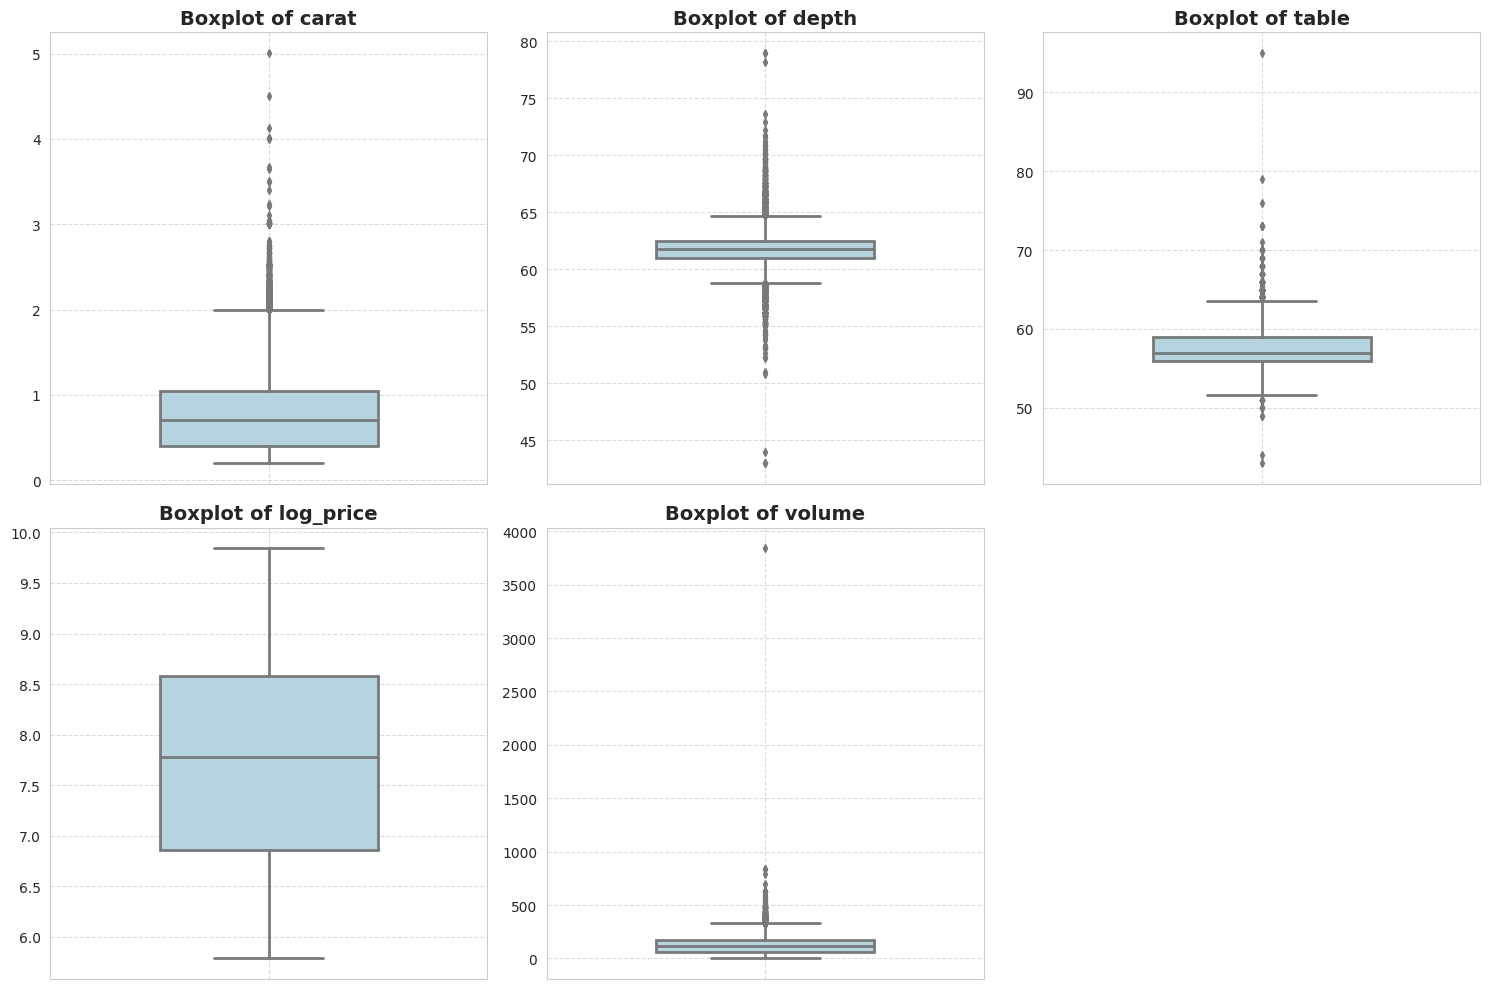

In [12]:
# Set Seaborn style for better visuals
sns.set_style("whitegrid")

# Define features to plot
features = ["carat", "depth", "table", "log_price", "volume"]

# Set figure size
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten the 2D array for easier iteration

# Create boxplots for each feature
for i, feature in enumerate(features):
    sns.boxplot(y=df_pre[feature], ax=axes[i], color="lightblue", width=0.5, linewidth=2, fliersize=4)
    axes[i].set_title(f"Boxplot of {feature}", fontsize=14, fontweight="bold")
    axes[i].set_ylabel("")  # Remove y-axis labels for cleaner look
    axes[i].grid(True, linestyle="--", alpha=0.7)  # Light grid for readability

# Remove empty subplot (since we have only 5 features)
fig.delaxes(axes[-1])

# Improve layout
plt.tight_layout()
plt.show()

### Isnights From BoxPlots: 

#### Carat
- most diamonds are small, with the middle 50% (IQR) between ~0.4 and 1.04 carats.
- lots of outliers above 2 carats (luxury diamonds).
- Implication: The carat distribution is right-skewed, and we may need a log transformation to reduce the impact of extreme values.

#### Depth
- most diamonds have depth around 60-62% (the ideal range).
- Outliers exist below 50% and above 70% (potentially poorly cut diamonds).
- Implication: Depth has weak correlation with price, so we might not need it as a key predictor.

#### Table 
- most diamonds have a table between 56-60%, which is within the recommended range.
- outliers exist below 50% and above 70% (unusual proportions).
- Implication: If extreme table values correlate with poor diamond quality, we might want to remove them.

#### Log Price
- no extreme outliers—the log transformation helped normalize price distribution.
- Implication: The model will perform better with log_price instead of raw price.

#### Volume
- huge range of values with many extreme outliers.
- some diamonds have volume = 0, which is a clear data error
- Implication:Diamonds cannot have zero volume, so these should be removed and the right-skewed distribution suggests we might need a log transformation.

In [5]:
# Remove Extreme Values from Depth
df_pre = df_pre[(df_pre["depth"] > 50) & (df_pre["depth"] < 70)]

#Remove Extreme Values from Table:
df_pre=df_pre[(df_pre["table"] < 50) | (df_pre["table"] > 70)]

#Remove 0 values from Volume
df_pre = df_pre[df_pre["volume"] > 0]

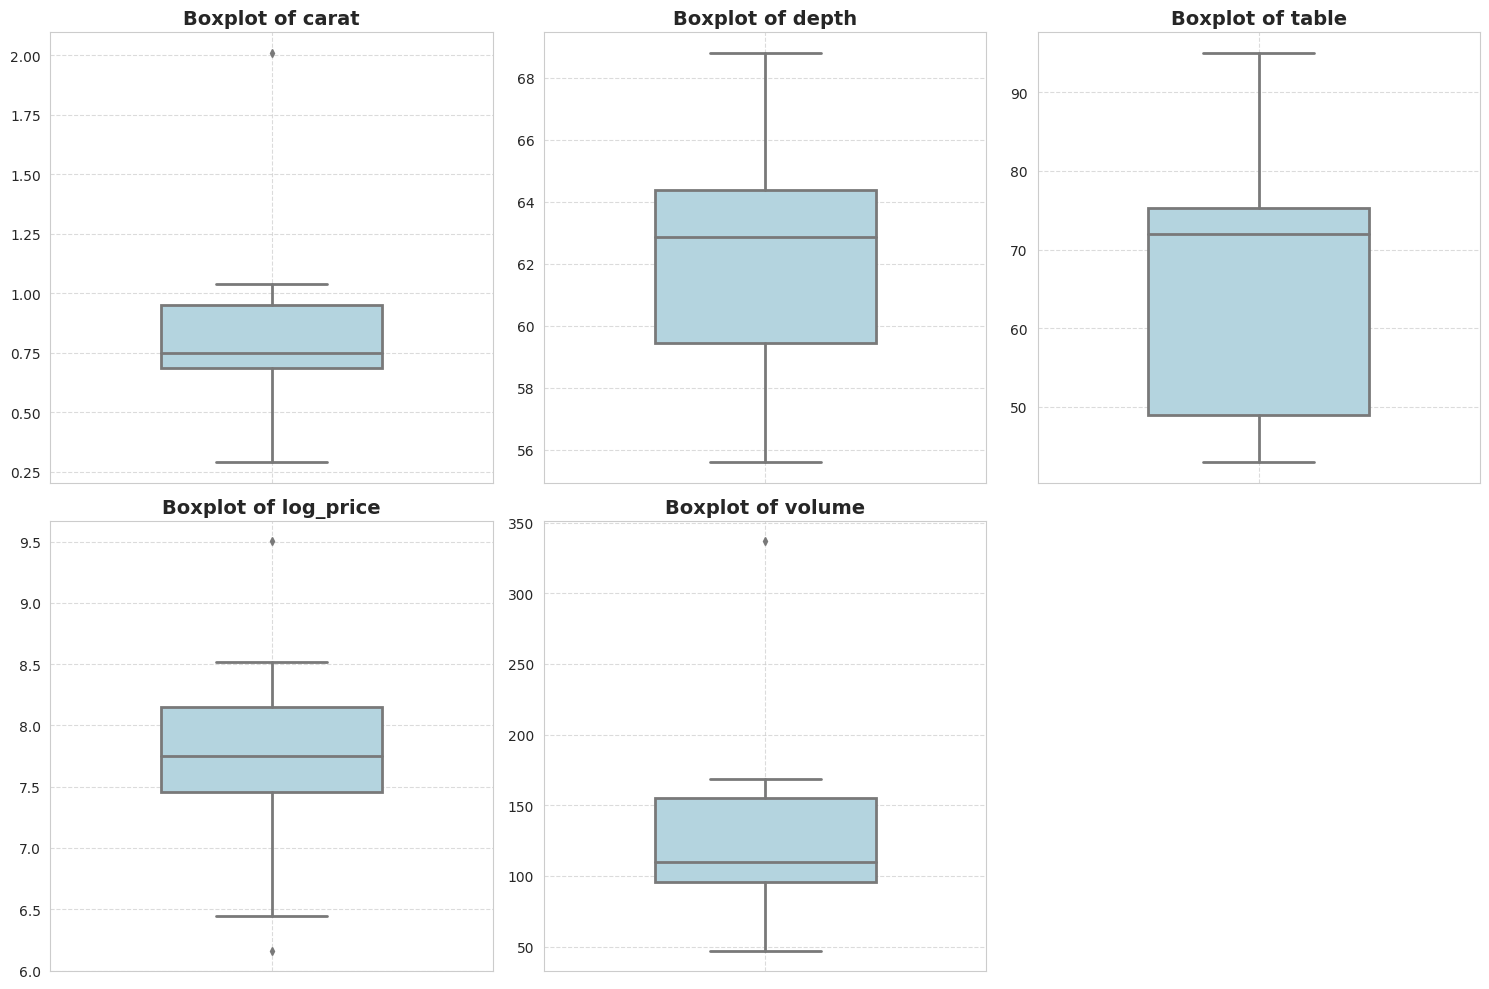

In [14]:
# Create a boxplot about the cleaned dataset:
# Set Seaborn style for better visuals
sns.set_style("whitegrid")

# Define features to plot
features = ["carat", "depth", "table", "log_price", "volume"]

# Set figure size
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten the 2D array for easier iteration

# Create boxplots for each feature
for i, feature in enumerate(features):
    sns.boxplot(y=df_pre[feature], ax=axes[i], color="lightblue", width=0.5, linewidth=2, fliersize=4)
    axes[i].set_title(f"Boxplot of {feature}", fontsize=14, fontweight="bold")
    axes[i].set_ylabel("")  # Remove y-axis labels for cleaner look
    axes[i].grid(True, linestyle="--", alpha=0.7)  # Light grid for readability

# Remove empty subplot (since we have only 5 features)
fig.delaxes(axes[-1])

# Improve layout
plt.tight_layout()
plt.show()

### Isnights From BoxPlots after removeing outliers
#### Carat
- Fewer outliers than before → Indicates that extreme carat values were removed.
- More compact interquartile range (IQR) → Now focuses on the most relevant diamonds.
- Implication: The dataset is now cleaner, with fewer extreme luxury diamonds distorting trends.
#### Depth
- No extreme low or high depth values → Likely removed depths below 50% and above 70%.
- Better symmetry → Depth values are now more focused within the optimal range (57-65%).
#### Table
- Less extreme spread compared to the previous version.
- Upper limit is now 90 instead of 95, and the lower limit is still around 50.
- Implication: Some high table values (85-90) still exist—might need further filtering.
#### Log Price
- More compact distribution → Fewer extreme values compared to the raw price boxplot.
#### Volume
- Zero-volume diamonds have been removed → Now starts above 50.
- Outliers are much less extreme—no more values in the thousands like before.
- Implication:One remaining extreme outlier (~300+) might still need investigation.

/tmp/ipykernel_27898/693838648.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_pre.corr(), annot=True, cmap="coolwarm", fmt=".2f")


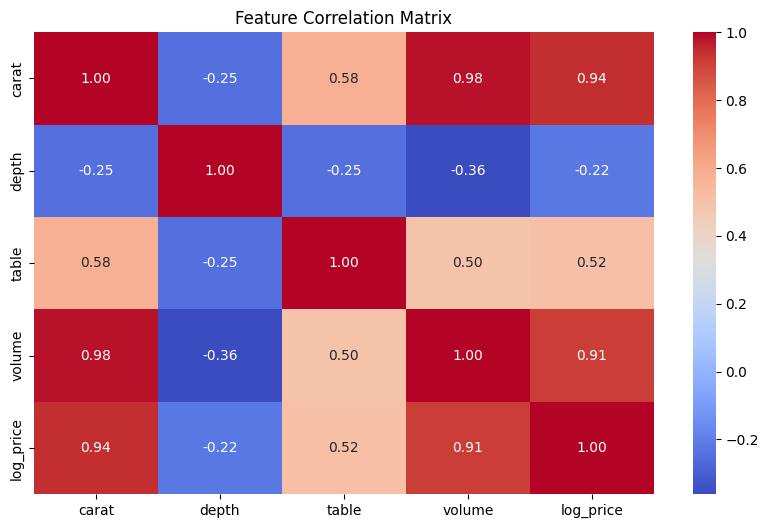

In [40]:
#Create Correlation HeatMap for the preprocessed data

plt.figure(figsize=(10, 6))
sns.heatmap(df_pre.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

### Insights
#### Carat and Volume
- Extremely high correlation, meaning they provide almost the same information.
- Drop one (probably volume) to reduce redundancy.
#### Carat and Log Price
- Strong positive correlation—Carat is a strong predictor of price.
#### Table and Log Price
- Moderate correlation, meaning Table has some influence on price
- Keep for now but monitor its importance.
#### Depth and Log Price
- Weak correlation, meaning Depth may not be very useful.
- Consider dropping Depth if models improve without it.

In [41]:
#Finalize the dataset and drop Volume and Depth
df_final=df_pre[["carat","cut",'color', 'clarity', "table", "log_price"]]

### MODEL TRAINING

In [42]:
# Define features and target variable
X = df_final.drop(columns=["log_price"])  # Features
y = df_final["log_price"]  # Target

In [43]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [53]:
# Data Preprocessing Function
def preprocess_data(df,use_polynomial=False):

    # Define features and target variable
    X = df.drop(columns=["log_price"])  # Features
    y = df["log_price"]  # Target variable

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Identify categorical and numerical columns
    categorical_features = ["cut", "color", "clarity"]
    numerical_features = X.select_dtypes(include=["float64", "int64"]).columns.difference(categorical_features)

    ### Encode Categorical Variables ###
    encoder = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)

    # Fit only on the training set
    X_train_encoded = encoder.fit_transform(X_train[categorical_features])
    X_test_encoded = encoder.transform(X_test[categorical_features])

    # Convert to DataFrame and retain column names
    train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_features))
    test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_features))

    # Drop original categorical features and concatenate encoded features
    X_train = X_train.drop(columns=categorical_features).reset_index(drop=True)
    X_test = X_test.drop(columns=categorical_features).reset_index(drop=True)

    X_train = pd.concat([X_train, train_encoded_df], axis=1)
    X_test = pd.concat([X_test, test_encoded_df], axis=1)

    # Scale Numerical Features
    scaler = StandardScaler()
    X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
    X_test[numerical_features] = scaler.transform(X_test[numerical_features])

    if use_polynomial:
        poly = PolynomialFeatures(degree=2, include_bias=False)
        X_train = poly.fit_transform(X_train)
        X_test = poly.transform(X_test)

    return X_train, X_test, y_train, y_test

In [54]:
### HyperParameter Tuning
def get_models():
    return {
        "Linear Regression": {
            "model": LinearRegression(),
            "params": {}  
        },
        "Ridge Regression": {
            "model": Ridge(),
            "params": {"alpha": [0.1, 1.0, 10.0, 50.0]}  
        },
        "Random Forest": {
            "model": RandomForestRegressor(random_state=42),
            "params": {
                "n_estimators": [100, 200],  # Increased trees
                "max_depth": [5, 7],  # Allow deeper trees
                "min_samples_split": [5, 10],  # Require more samples per split
                "min_samples_leaf": [3, 5],  # Allow smaller leaves
                "max_features": ["sqrt", "log2"]
            }
        },
        "Gradient Boosting": {
            "model": GradientBoostingRegressor(random_state=42),
            "params": {
                "n_estimators": [100, 200],  # Increased trees
                "learning_rate": [0.01, 0.05],  # Adjust learning rate
                "max_depth": [3, 4],  # Allow deeper trees
                "min_samples_leaf": [3, 5],
            }
        },
        "XGBoost": {
            "model": xgb.XGBRegressor(random_state=42),
            "params": {
                "n_estimators": [50, 100],  # Reduce trees
                "learning_rate": [0.005, 0.01],  # Lower learning rate for better generalization
                "max_depth": [1, 2],  # Even shallower trees
                "min_child_weight": [5, 10],  # Penalize small splits
                "colsample_bytree": [0.5, 0.7],  # Reduce feature usage per tree
                "subsample": [0.5, 0.7],  # Reduce sample usage per tree
                "gamma": [0.1, 0.3]
            }
        }
    }


### 🔹 Step 3: Model Training & Evaluation ###
def evaluate_model(model_info, X_train, X_test, y_train, y_test, model_name):
    """Trains a model using GridSearchCV, evaluates performance, and returns results."""

    print(f"\nTraining {model_name}...")
    
    grid_search = GridSearchCV(model_info["model"], model_info["params"], cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Train & Test Metrics
    metrics = {
        "Model": model_name,
        "Best Params": grid_search.best_params_,
        "Train MAE": mean_absolute_error(y_train, y_train_pred),
        "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "Train R2 Score": r2_score(y_train, y_train_pred),
        "Test MAE": mean_absolute_error(y_test, y_test_pred),
        "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred)),
        "Test R2 Score": r2_score(y_test, y_test_pred),
    }

    return metrics, best_model


### 🔹 Step 4: Train All Models & Compare ###
def train_and_compare_models(models, X_train, X_test, y_train, y_test):
    """Trains all models, stores results, and returns a DataFrame of model performance."""

    results = []
    best_model = None
    best_score = float("-inf")

    for model_name, model_info in models.items():
        metrics, best_trained_model = evaluate_model(model_info, X_train, X_test, y_train, y_test, model_name)
        results.append(metrics)

        # Update best model
        if metrics["Test R2 Score"] > best_score:
            best_score = metrics["Test R2 Score"]
            best_model = best_trained_model

    return pd.DataFrame(results).sort_values(by="Test MAE"), best_model


### 🔹 Step 5: Visualize Model Performance ###
def plot_model_performance(results_df):
    """Plots model comparison for Train & Test MAE."""

    plt.figure(figsize=(12, 6))

    # Train vs Test MAE Comparison
    plt.subplot(1, 2, 1)
    sns.barplot(data=results_df, x="Model", y="Train MAE", palette="Blues")
    plt.title("Train Set: Mean Absolute Error (MAE)")
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    sns.barplot(data=results_df, x="Model", y="Test MAE", palette="Reds")
    plt.title("Test Set: Mean Absolute Error (MAE)")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [56]:
## Training on the DataSet Round 1
# Preprocess data
X_train, X_test, y_train, y_test = preprocess_data(df_final, use_polynomial=True)

# Get models
models = get_models()

# Train and compare models
results_df, best_model = train_and_compare_models(models, X_train, X_test, y_train, y_test)

# Print results

pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.expand_frame_repr", False)  # Prevent line wrapping
pd.set_option("display.max_colwidth", None)  # Fully show long text

# Print full results
print("\nModel Performance Summary:")
print(results_df)

/opt/blue-python/3.10/lib64/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Training Linear Regression...

Training Ridge Regression...

Training Random Forest...

Training Gradient Boosting...

Training XGBoost...

Model Performance Summary:
               Model                                                                                                                                   Best Params     Train MAE    Train RMSE  Train R2 Score  Test MAE  Test RMSE  Test R2 Score
0  Linear Regression                                                                                                                                            {}  6.661338e-16  1.174950e-15        1.000000  0.194690   0.202852       0.706862
1   Ridge Regression                                                                                                                                {'alpha': 0.1}  6.065102e-03  7.300764e-03        0.999944  0.198590   0.204359       0.702489
2      Random Forest                                  {'max_depth': 5, 'max_features': 'sqrt', 'min_sam

### Conclusions
1. Linear Regression is the best performing model, indicating a linear relationship between features and price.
2. Ridge Regression is similar to Linear Regression, meaning regularization is not necessary.
3. andom Forest is not capturing patterns at all.
4. XGBoost is failing 
5. XGBoost performs poorly on the test set.

### FIX
Some Features may not be helping tree-based models, therefore we check the feture importance

In [62]:
print("Feature Importances:", best_xgb.feature_importances_)

Feature Importances: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]


### Insights

#### Feature importances are all zero:
1. Extremely Shallow Trees (max_depth=1) → Trees are too simple to capture feature importance.
2. Too Few Trees (n_estimators=100) → Not enough boosting rounds to learn relationships.
3. Learning Rate Too Low (learning_rate=0.01) → The model learns too slowly, preventing meaningful splits.
4. min_child_weight=5 Preventing Splits → Restricts the model from learning smaller patterns.

#### Fix
Increase max_depth, n_estimators, and learning_rate

/opt/blue-python/3.10/lib64/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Training XGBoost...

Model Performance Summary:
     Model                                                                                                                                   Best Params  Train MAE  Train RMSE  Train R2 Score  Test MAE  Test RMSE  Test R2 Score
0  XGBoost  {'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.5}   0.156157    0.198203        0.958507  0.249219   0.266858       0.492687

Extracting feature importances from best XGBoost model...


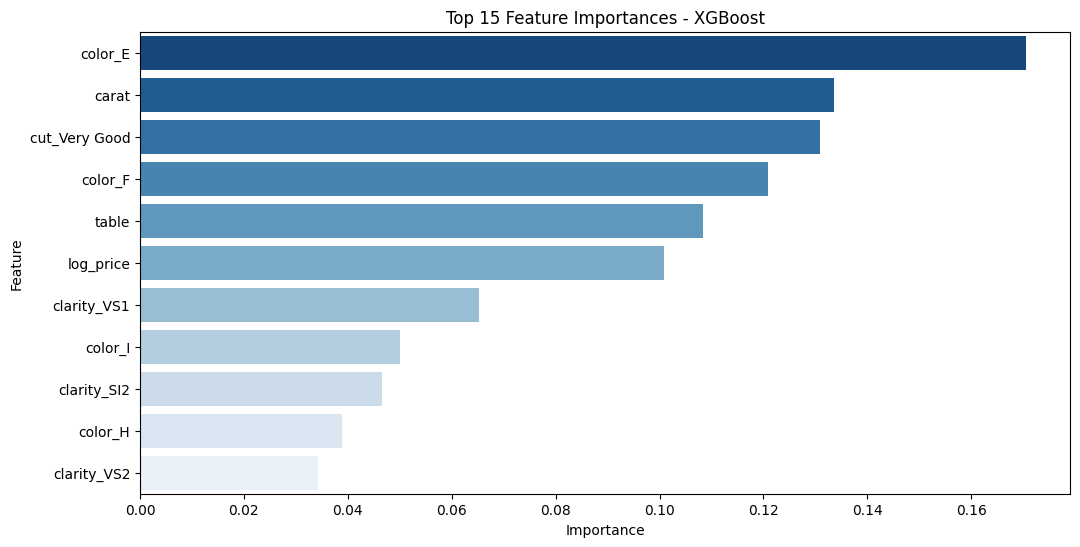

In [75]:
def get_models():
    return {
        "XGBoost": {
    "model": xgb.XGBRegressor(random_state=42),
    "params": {
        "n_estimators": [200, 300],  # More boosting rounds
        "learning_rate": [0.01, 0.05],  # Slightly higher LR
        "max_depth": [3, 4],  # Allow deeper splits
        "min_child_weight": [1, 3],  # Allow smaller splits
        "colsample_bytree": [0.5, 0.7],  
        "subsample": [0.5, 0.7],  
        "gamma": [0.1, 0.3]  # Reduce overfitting
    }
}
    }

## Training on the DataSet Round 1
# Preprocess data
X_train, X_test, y_train, y_test = preprocess_data(df_final, use_polynomial=False)

# Get models
models = get_models()

# Train and compare models
results_df, best_model = train_and_compare_models(models, X_train, X_test, y_train, y_test)

# Print results

pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.expand_frame_repr", False)  # Prevent line wrapping
pd.set_option("display.max_colwidth", None)  # Fully show long text

# Print full results
print("\nModel Performance Summary:")
print(results_df)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get categorical feature names from encoder
categorical_feature_names = encoder.get_feature_names_out(categorical_features).tolist()

# Get numerical feature names from original dataframe
numerical_feature_names = df_final.select_dtypes(include=["float64", "int64"]).columns.difference(categorical_features).tolist()

# Combine numerical & categorical feature names
feature_names = numerical_feature_names + categorical_feature_names

# Ensure best_model is XGBoost
if isinstance(best_model, xgb.XGBRegressor):
    print("\nExtracting feature importances from best XGBoost model...")

    # Retrieve feature importances
    importances = best_model.feature_importances_

    # Ensure feature_names matches the number of features in X_train
    if len(feature_names) != len(importances):
        print(f"Warning: Feature names ({len(feature_names)}) do not match importances ({len(importances)}).")
        feature_names = [f"Feature_{i}" for i in range(len(importances))]  # Fallback to generic names

    # Create DataFrame for visualization
    feature_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
    feature_df = feature_df.sort_values(by="Importance", ascending=False)

    # Plot Feature Importance
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_df[:15], x="Importance", y="Feature", palette="Blues_r")
    plt.title("Top 15 Feature Importances - XGBoost")
    plt.show()

else:
    print("\nError: Best model is not XGBoost. Check your training results.")



In [24]:
# Print Best Model Summary
print("\nBest Model Selected:")
print(best_model)


Best Model Selected:
GradientBoostingRegressor(n_estimators=200, random_state=42)
